In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import glob
import geopandas
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from shapely import geometry
from datetime import datetime

## Model Training

In [3]:
combined_gdf_clean_dup_removed = geopandas.read_file('../../data/interim/multisat_singlesat_grid_1km_buffer_apr_sep_2019_clean.geojson')

In [4]:
combined_gdf_clean_dup_removed.drop(columns=['end_date', 'start_date', 'period'], inplace=True)

In [5]:
combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed['truth_flag'] == -1, 'truth_flag'] = 1

In [5]:
#assign weight of hotspot grid to be 0 for missed detections
#combined_gdf_clean_dup_removed.loc[combined_gdf_clean_dup_removed.id_grid.isna(), ['polar_weight', 'geo_weight', 'weight']] = 0

In [7]:
predict_gdf = combined_gdf_clean_dup_removed[['terra_weight', 'n20_weight', 'aqua_weight', 'npp_weight', 'geo_weight', 'truth_flag']]
predict_gdf.reset_index(inplace=True,drop=True)
predict_gdf.head()

,terra_weight,n20_weight,aqua_weight,npp_weight,geo_weight,truth_flag
0,0.00,0.0,0.00,0.64,0.000000,1.0
1,0.47,0.0,0.53,0.60,0.000000,1.0
2,1.47,0.0,0.80,0.00,0.098398,1.0
3,0.76,0.0,0.85,1.41,0.145062,1.0
4,0.47,0.0,0.53,0.00,0.000000,1.0


In [8]:
predict_features =['terra_weight', 'n20_weight', 'aqua_weight', 'npp_weight', 'geo_weight']

In [9]:
#for training purpose, we remove the missed detections
predict_gdf_no_FN = predict_gdf.dropna(subset=predict_features)

In [10]:
print (f'Percentage of Missed Detections : {(len(predict_gdf)-len(predict_gdf_no_FN))/len(predict_gdf) * 100}%')

Percentage of Missed Detections : 6.688390404484135%


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

training_df, test_df = train_test_split(predict_gdf_no_FN[[*predict_features, 'truth_flag']], test_size=0.2, random_state=123, shuffle=True)

training_minority_df = training_df[(training_df['truth_flag'] == 1)]
training_majority_df = training_df[(training_df['truth_flag'] == 0)]

training_downsampled_df = resample(training_majority_df, replace=False, 
                                   n_samples=len(training_minority_df), random_state=123)

training_balanced_df = pd.concat([training_downsampled_df, training_minority_df])

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss
from sklearn.metrics import roc_curve

In [13]:
#Setup the grid search params and model choices
model_param_json = {
    'LR': {
        'clf': LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
        'param_grid': [
            { 'clf__C': [0.5, 1.0, 1.5, 2.5],
             'clf__penalty': ['none', 'l1', 'l2'],
             'clf__fit_intercept': [True],
            'clf__solver': ['saga']},
        ]
    }
}

Now we assess the model performance

In [14]:
model_eval = {}
model_eval_df = pd.DataFrame()

for model in model_param_json.keys():
        
    clf_pipeline = Pipeline([('clf', model_param_json[model]['clf'])])

    gs_clf = GridSearchCV(estimator=clf_pipeline, 
                           param_grid=model_param_json[model]['param_grid'], 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=3, 
                           refit=True,
                           pre_dispatch='2*n_jobs')
    
    gs_clf.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])

    print (f'Best estimator : {gs_clf.best_estimator_}')
    print (f'Best params : {gs_clf.best_params_}')
    
    model_eval['best_estimator'] = gs_clf.best_estimator_
    model_eval['params'] = gs_clf.best_params_
    
    y_prob = gs_clf.predict_proba(test_df[predict_features])[:,1]   
    y_pred = gs_clf.predict(test_df[predict_features])
    
    fpr, tpr, thresholds = roc_curve(test_df['truth_flag'], y_prob)
    csi = 1/((1/(1-fpr)) + (1/tpr) - 1)

    model_eval['roc'] = roc_auc_score(y_true=test_df['truth_flag'], y_score=y_prob)
    model_eval['brier_score_loss'] = brier_score_loss(y_true=test_df['truth_flag'], y_prob=y_prob)
    model_eval['f1_score'] = f1_score(y_true=test_df['truth_flag'], y_pred=y_pred)
    model_eval['csi_max'] = csi.max()
    model_eval['tpr'] = tpr[csi.argmax()]
    model_eval['fpr'] = fpr[csi.argmax()]
    model_eval['threshold'] = thresholds[csi.argmax()]
    
    model_eval_df = model_eval_df.append(model_eval, ignore_index=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.4s


Best estimator : Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='none', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best params : {'clf__C': 1.0, 'clf__fit_intercept': True, 'clf__penalty': 'none', 'clf__solver': 'saga'}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.5s finished
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [15]:
model_eval_df

,best_estimator,brier_score_loss,csi_max,f1_score,fpr,params,roc,threshold,tpr
0,"(LogisticRegression(C=1.0, class_weight=None, ...",0.159699,0.592113,0.526247,0.226522,"{'clf__C': 1.0, 'clf__fit_intercept': True, 'c...",0.841624,0.404584,0.71633


### Model Selection 

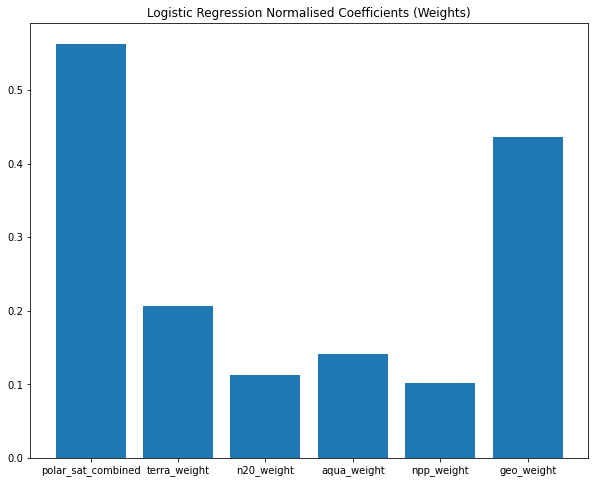

In [178]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
total_coeff_weight = best_pipe.steps[0][1].coef_[0].sum()
ax.bar(x=['polar_sat_combined', *predict_features], height=[best_pipe.steps[0][1].coef_[0][:4].sum(), *best_pipe.steps[0][1].coef_[0]]/total_coeff_weight)
_ = ax.set_title('Logistic Regression Normalised Coefficients (Weights)')

From the logistic regression function, we see that the best combo favours the contribution of Himawari-8 significantly over the polar-orbiters. N-20 and NPP satellites actually contribute to the smallest weights. 

In [191]:
algo_df = pd.DataFrame()

In [192]:
best_pipe = eval(str(model_eval_df.loc[0, 'best_estimator']))
best_pipe.set_params(**eval(str(model_eval_df.loc[0, 'params'])))
best_pipe.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])
test_df['fusiun_prob'] = best_pipe.predict_proba(test_df[predict_features])[:, 1]

In [193]:
#save model params
import pickle
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
dump(best_pipe, '../../models/fusiun_lr_best_pipe_sklearn_0.22.sav') 
best_pipe = load('../../models/fusiun_lr_best_pipe_sklearn_0.22.sav') 

In [195]:
best_pipe

Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='none', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [196]:
algo_dict = {'TERRA': 'terra_weight', 'AQUA': 'aqua_weight', 'NPP': 'npp_weight', 
             'N20': 'n20_weight', 'H8_GB': 'geo_weight', 'FUSIUN': 'fusiun_prob'}

In [197]:
algo_eval = {}
for key, val in algo_dict.items():
    y_prob = np.clip(test_df[val], 0, 1)
    algo_eval['algo'] = key
    algo_eval['roc'] = roc_auc_score(y_true=test_df['truth_flag'], y_score= y_prob)
    algo_eval['brier_score_loss'] = brier_score_loss(y_true=test_df['truth_flag'], y_prob=y_prob)
    
    fpr, tpr, thresholds = roc_curve(test_df['truth_flag'], y_prob)
    csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
    algo_eval['csi_max'] = csi.max()
    algo_eval['tpr'] = tpr[csi.argmax()]
    algo_eval['fpr'] = fpr[csi.argmax()]
    algo_eval['threshold'] = thresholds[csi.argmax()]
    algo_df = algo_df.append(algo_eval, ignore_index=True)

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [198]:
algo_df

,algo,brier_score_loss,csi_max,fpr,roc,threshold,tpr
0,TERRA,0.146747,0.194017,0.031019,0.582853,0.120000,0.195229
1,AQUA,0.144768,0.311599,0.068441,0.628485,0.140000,0.318899
2,NPP,0.164062,0.351314,0.118953,0.630384,0.150000,0.368807
3,N20,0.162871,0.353679,0.118739,0.632161,0.120000,0.371376
4,H8_GB,0.124070,0.549458,0.238261,0.723006,0.018509,0.663486
5,FUSIUN,0.159698,0.592113,0.226522,0.841624,0.404583,0.716330


Text(0.5, 1.0, 'Performance of Hotspot Algorithms')

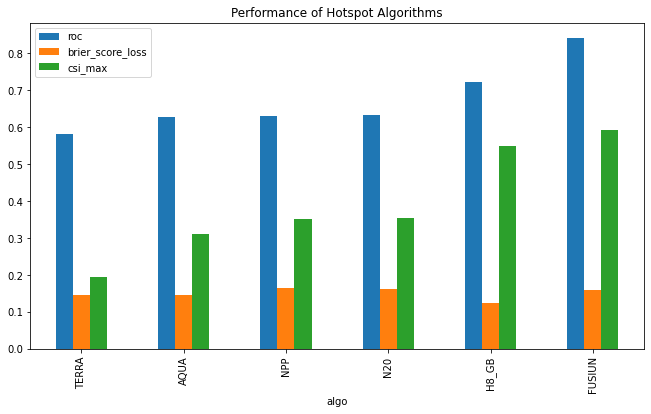

In [199]:
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot()
algo_df.sort_values(by=['roc']).plot.bar(ax=ax, x='algo', y=['roc', 'brier_score_loss', 'csi_max'])
ax.set_title('Performance of Hotspot Algorithms')

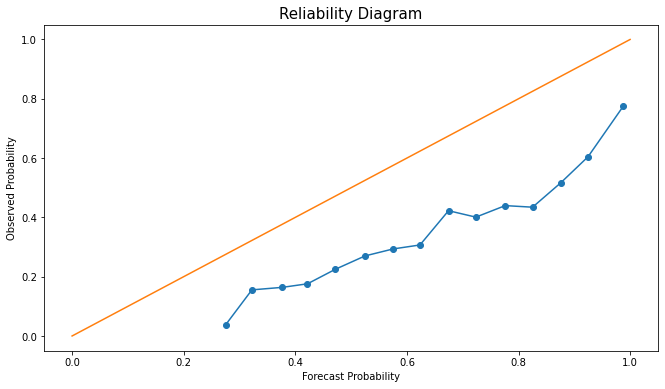

In [200]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_df['truth_flag'], test_df['fusiun_prob'], n_bins=20)
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot()
ax.plot(prob_pred, prob_true, marker='o')
ax.plot([0, 1], [0, 1])
ax.set_xlabel('Forecast Probability')
ax.set_ylabel('Observed Probability')
_ = ax.set_title('Reliability Diagram', {'fontsize': 15})

In [201]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = test_df['truth_flag'], y_score = test_df['fusiun_prob'])
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = test_df['truth_flag'], y_score = test_df['fusiun_prob'])

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


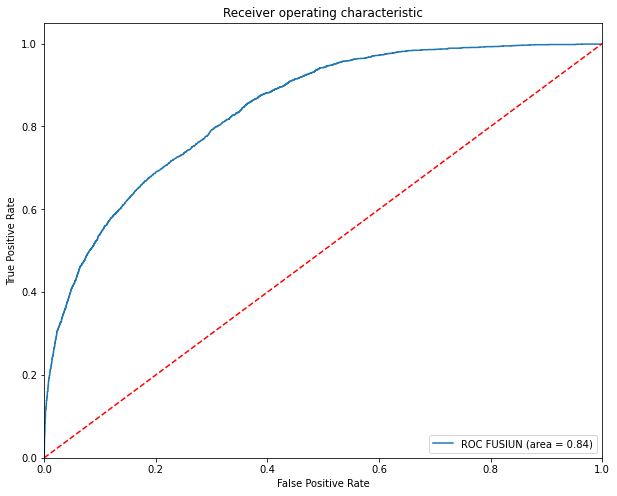

In [202]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='ROC FUSIUN (area = %0.2f)' % roc)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

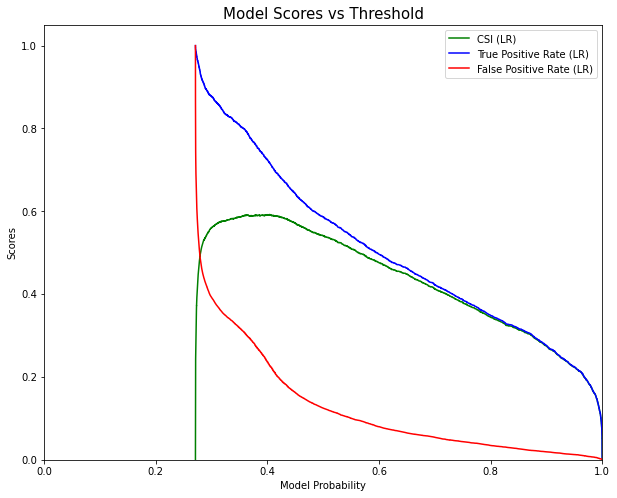

In [203]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds, csi, 'g', label='CSI (LR)')
plt.plot(thresholds, tpr, 'b', label='True Positive Rate (LR)')
plt.plot(thresholds, fpr, 'r', label='False Positive Rate (LR)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.set_title('Model Scores vs Threshold', fontsize=15)
_ = ax.legend(loc="upper right")

## Assessing Model Performance with Missed Detections

In [204]:
filter_na = predict_gdf['n20_weight'].isna()

In [205]:
len(predict_gdf.loc[filter_na])/len(predict_gdf.loc[predict_gdf['truth_flag'] == 1])

0.3095372896186114

In [206]:
predict_gdf.loc[filter_na, 'model_prob'] = 0

C:\Anaconda3\envs\fred_linux\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [207]:
predict_gdf.loc[~filter_na, 'model_prob'] = best_pipe.predict_proba(predict_gdf.loc[~filter_na, predict_features])[:, 1]

C:\Anaconda3\envs\fred_linux\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [208]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = predict_gdf['truth_flag'], y_score = predict_gdf['model_prob'])
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = predict_gdf['truth_flag'], y_score = predict_gdf['model_prob'])

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


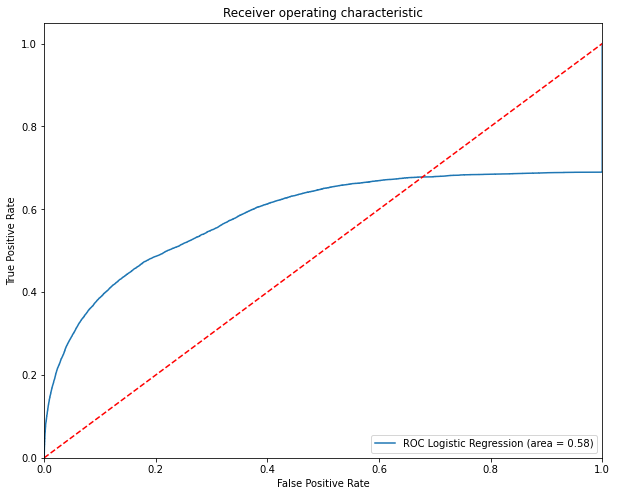

In [209]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='ROC Logistic Regression (area = %0.2f)' % roc)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

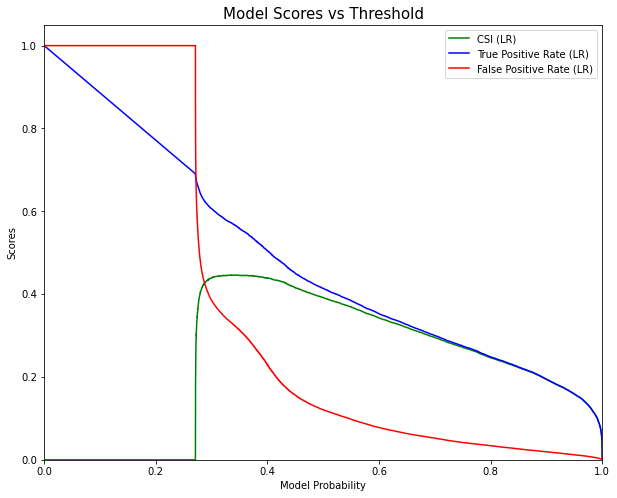

In [210]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds, csi, 'g', label='CSI (LR)')
plt.plot(thresholds, tpr, 'b', label='True Positive Rate (LR)')
plt.plot(thresholds, fpr, 'r', label='False Positive Rate (LR)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.set_title('Model Scores vs Threshold', fontsize=15)
_ = ax.legend(loc="upper right")